In [1]:
# **Visual Summary of this Dataset**

Each patient directory has 2 sub-folders, labeled 1 and 0 <br>
class 0:  Non-Invasive Ductal Carcinoma (IDC){in situ} <br>
class 1 : Invasive Ductal Carcinoma (IDC){invasive}

In [2]:
#load packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#VISUALIZATION
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import seaborn as sns
from skimage import io
sns.set()

#MACHINELEARNING
from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA

from glob import glob
from os import listdir
import pickle

from tqdm.notebook import tqdm
tqdm().pandas();

0it [00:00, ?it/s]

In [3]:
files = listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5")
print(f'total number of subfolders inside our folder: {len(files)}')
print(f'preview of first 10 subfolders:')
print(files[0:10])

total number of subfolders inside our folder: 279
preview of first 10 subfolders:
['10295', '10304', '12868', '10274', '12818', '14190', '12869', '9323', '10291', '12906']


In [4]:
patient_folder = listdir("../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689")
print(f'number of subfolders inside patient number folder: {len(patient_folder)}')


number of subfolders inside patient number folder: 2


In [5]:
from pprint import pprint
class_0 = listdir('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/0')
class_1 = listdir('../input/breast-histopathology-images/IDC_regular_ps50_idx5/13689/1')

print(f'Contents of folder 0:')
pprint(class_0[0:5])
print()
print(f'Contents of folder 1:')
pprint(class_1[0:5])

Contents of folder 0:
['13689_idx5_x201_y1351_class0.png',
 '13689_idx5_x1301_y601_class0.png',
 '13689_idx5_x1151_y451_class0.png',
 '13689_idx5_x1151_y1301_class0.png',
 '13689_idx5_x1951_y801_class0.png']

Contents of folder 1:
['13689_idx5_x951_y1501_class1.png',
 '13689_idx5_x951_y1351_class1.png',
 '13689_idx5_x651_y601_class1.png',
 '13689_idx5_x851_y1351_class1.png',
 '13689_idx5_x1001_y1501_class1.png']


In [6]:
base_path = '../input/breast-histopathology-images/IDC_regular_ps50_idx5/'
# We will save the base path to the patient folders, so that we can easily loop over them
patient_ids = listdir(base_path)

In [7]:
class_0_total = 0
class_1_total = 0
from pprint import pprint
for patient_id in patient_ids:
    class_0_files = listdir(base_path + patient_id + '/0')
    class_1_files = listdir(base_path + patient_id + '/1')

    class_0_total += len(class_0_files)
    class_1_total += len(class_1_files) 

total_images = class_0_total + class_1_total
    
print(f'Number of patches in Class 0: {class_0_total}')
print(f'Number of patches in Class 1: {class_1_total}')
print(f'Total number of patches: {total_images}')

Number of patches in Class 0: 198738
Number of patches in Class 1: 78786
Total number of patches: 277524


In [8]:
columns = ["patient_id",'x','y',"target","path"]
data_rows = []
i = 0
iss = 0
isss = 0

# note that we loop through the classes after looping through the 
# patient ids so that we avoid splitting our data into [all class 0 then all class 1]
for patient_id in tqdm(patient_ids):
    for c in [0,1]:
        class_path = base_path + patient_id + '/' + str(c) + '/'
        imgs = listdir(class_path)
        
        # Extracting Image Paths
        img_paths = [class_path + img + '/' for img in imgs]
        
        # Extracting Image Coordinates
        img_coords = [img.split('_',4)[2:4] for img in imgs]
        x_coords = [int(coords[0][1:]) for coords in img_coords]
        y_coords = [int(coords[1][1:]) for coords in img_coords]

        for (path,x,y) in zip(img_paths,x_coords,y_coords):
            values = [patient_id,x,y,c,path]
            data_rows.append({k:v for (k,v) in zip(columns,values)})
# We create a new dataframe using the list of dicts that we generated above
data = pd.DataFrame(data_rows)
print(f'Shape of Dataframe: {data.shape}')
data.head()

  0%|          | 0/279 [00:00<?, ?it/s]

Shape of Dataframe: (277524, 5)


,patient_id,x,y,target,path
0,10295,1351,1101,0,../input/breast-histopathology-images/IDC_regu...
1,10295,1501,501,0,../input/breast-histopathology-images/IDC_regu...
2,10295,1501,1101,0,../input/breast-histopathology-images/IDC_regu...
3,10295,451,901,0,../input/breast-histopathology-images/IDC_regu...
4,10295,801,451,0,../input/breast-histopathology-images/IDC_regu...


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, '% of patches with IDC')

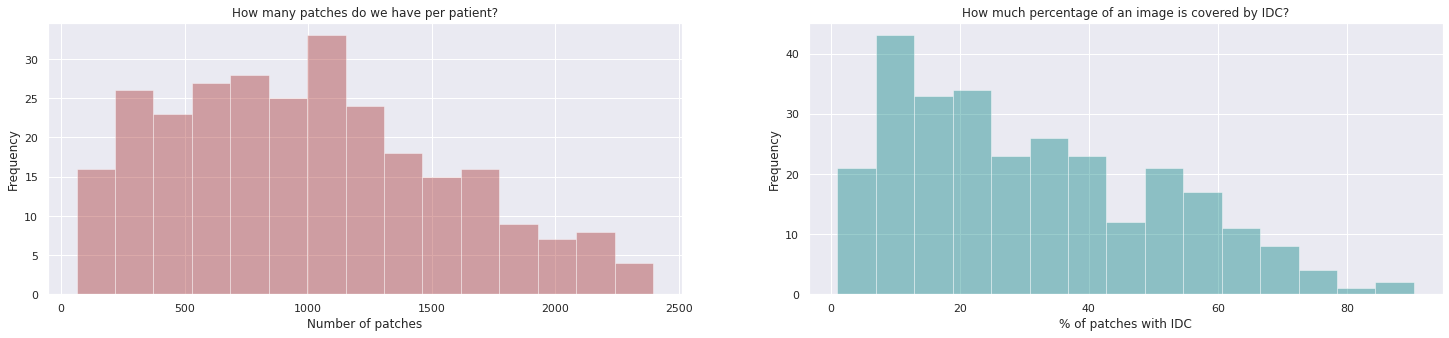

In [9]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,2,figsize=(25,5))

# Plotting Frequency of Patches per Patient
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="brown", kde=False, bins=15)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

# Plotting Percentage of an image that is covered by Invasive Ductile Carcinoma
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="teal", kde=False, bins=15)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# # Plotting number of patches that show IDC
# sns.countplot(data.target, palette='deep', ax=ax[2]);
# ax[2].set_ylabel("Count")
# ax[2].set_xlabel("no(0) versus yes(1)")
# ax[2].set_title("How many patches show IDC?");

# **Healthy Tissue Patches Vs Cancerous Tissue Patches**

In [10]:
positive_tissue = np.random.choice(data[data.target==1].index.values, size=100, replace=False)
negative_tissue = np.random.choice(data[data.target==0].index.values, size=100, replace=False)

n_rows = 5
n_cols = 5

# **Cancerous Patches**

  0%|          | 0/5 [00:00<?, ?it/s]

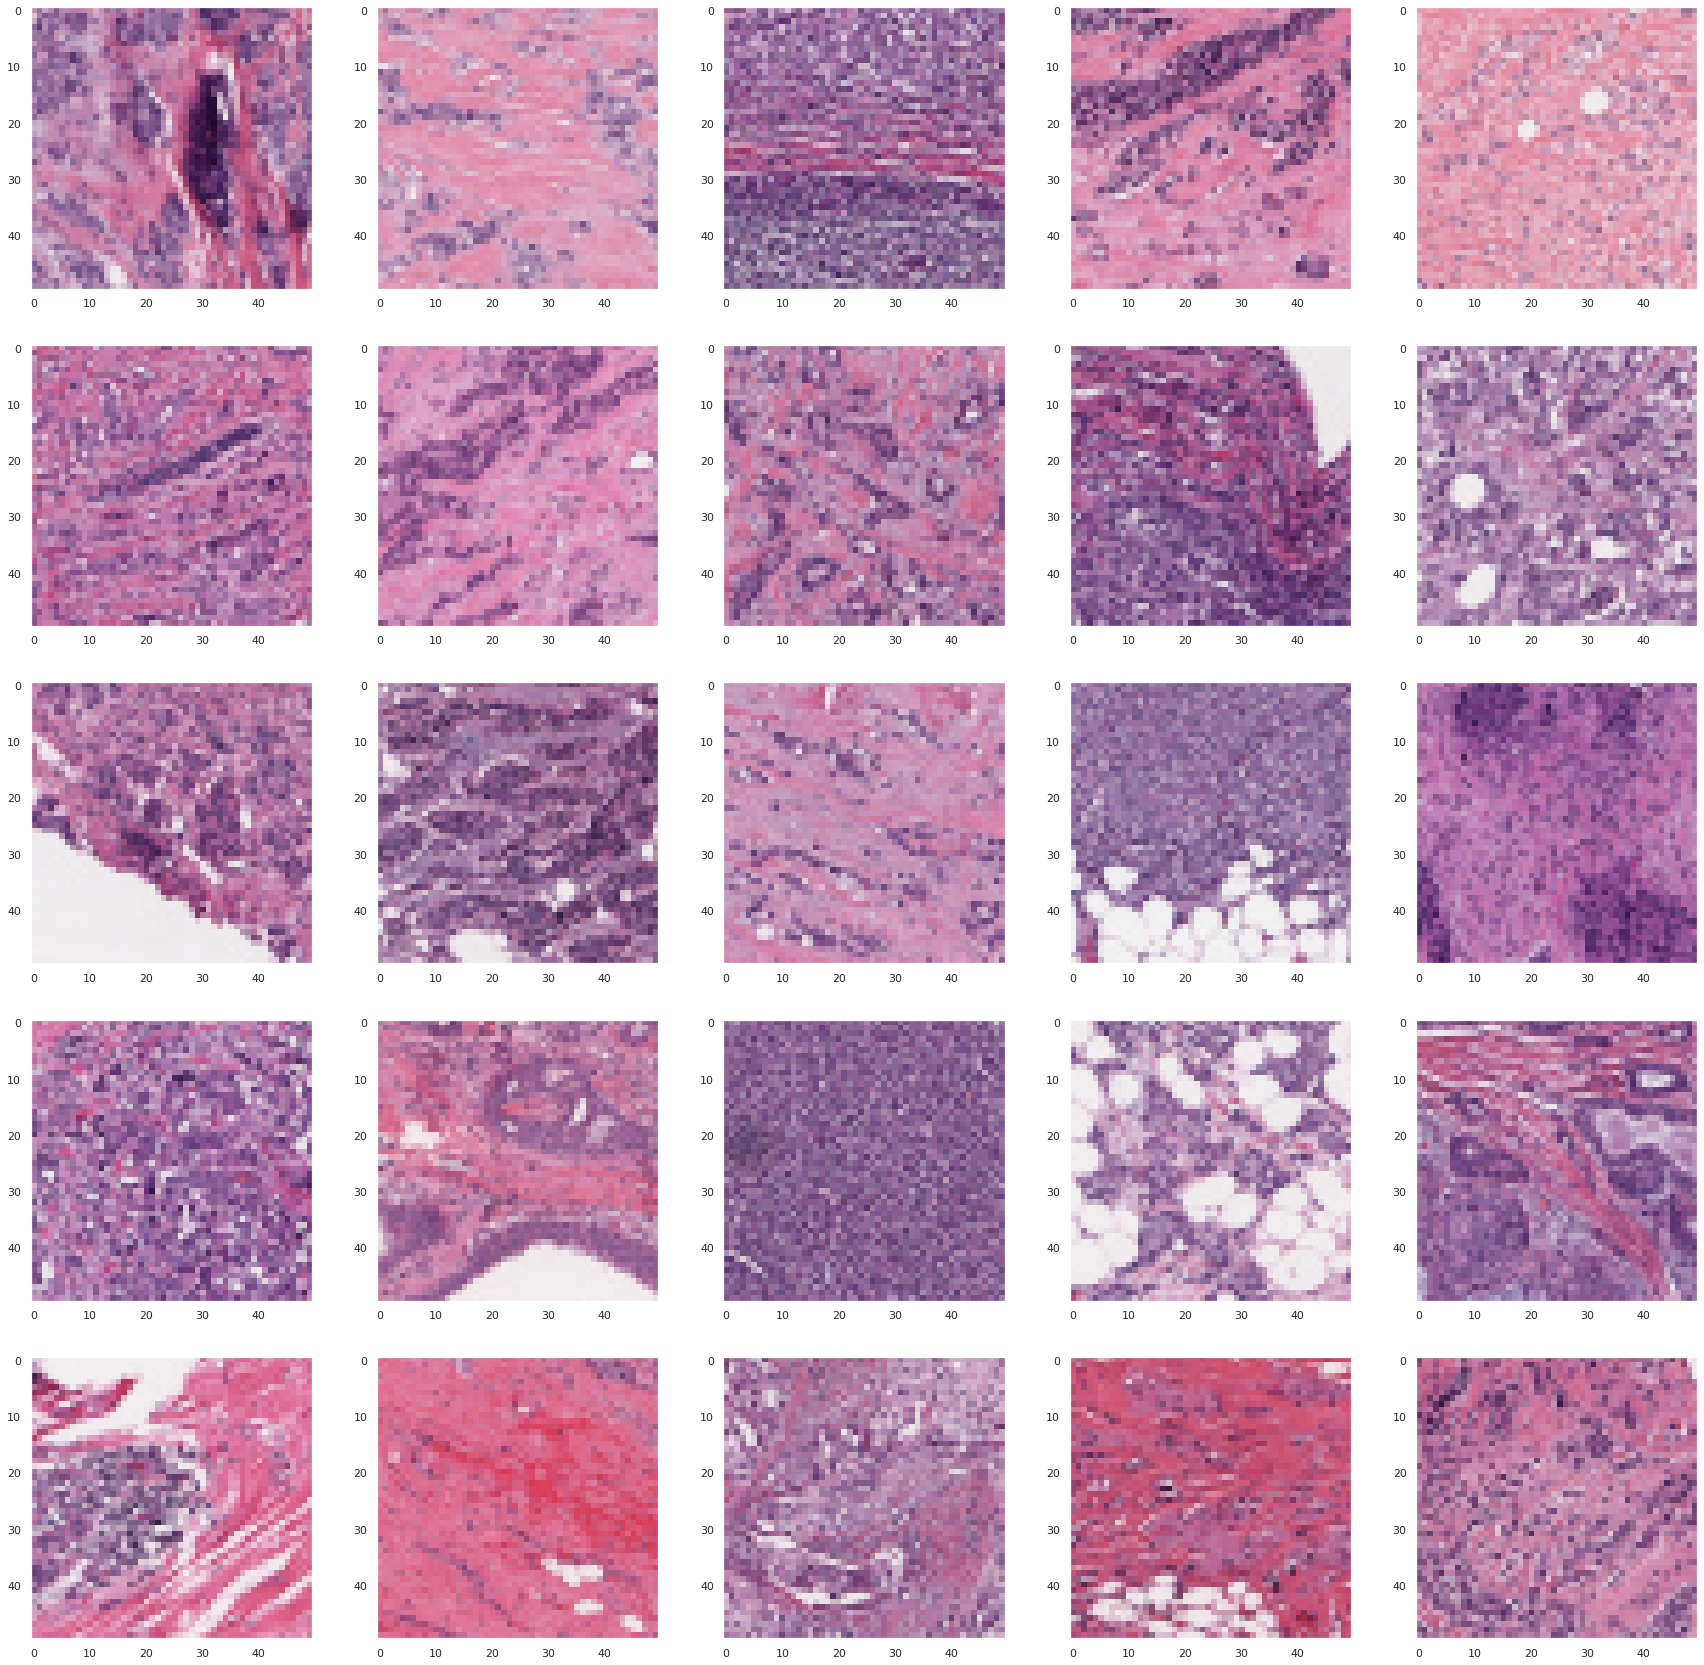

In [11]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in tqdm(range(n_rows)):
    for col in range(n_cols):
        # below is a counter to cycle through the image indexes
        idx = positive_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

# **Non-Cancerous Patches**


  0%|          | 0/5 [00:00<?, ?it/s]

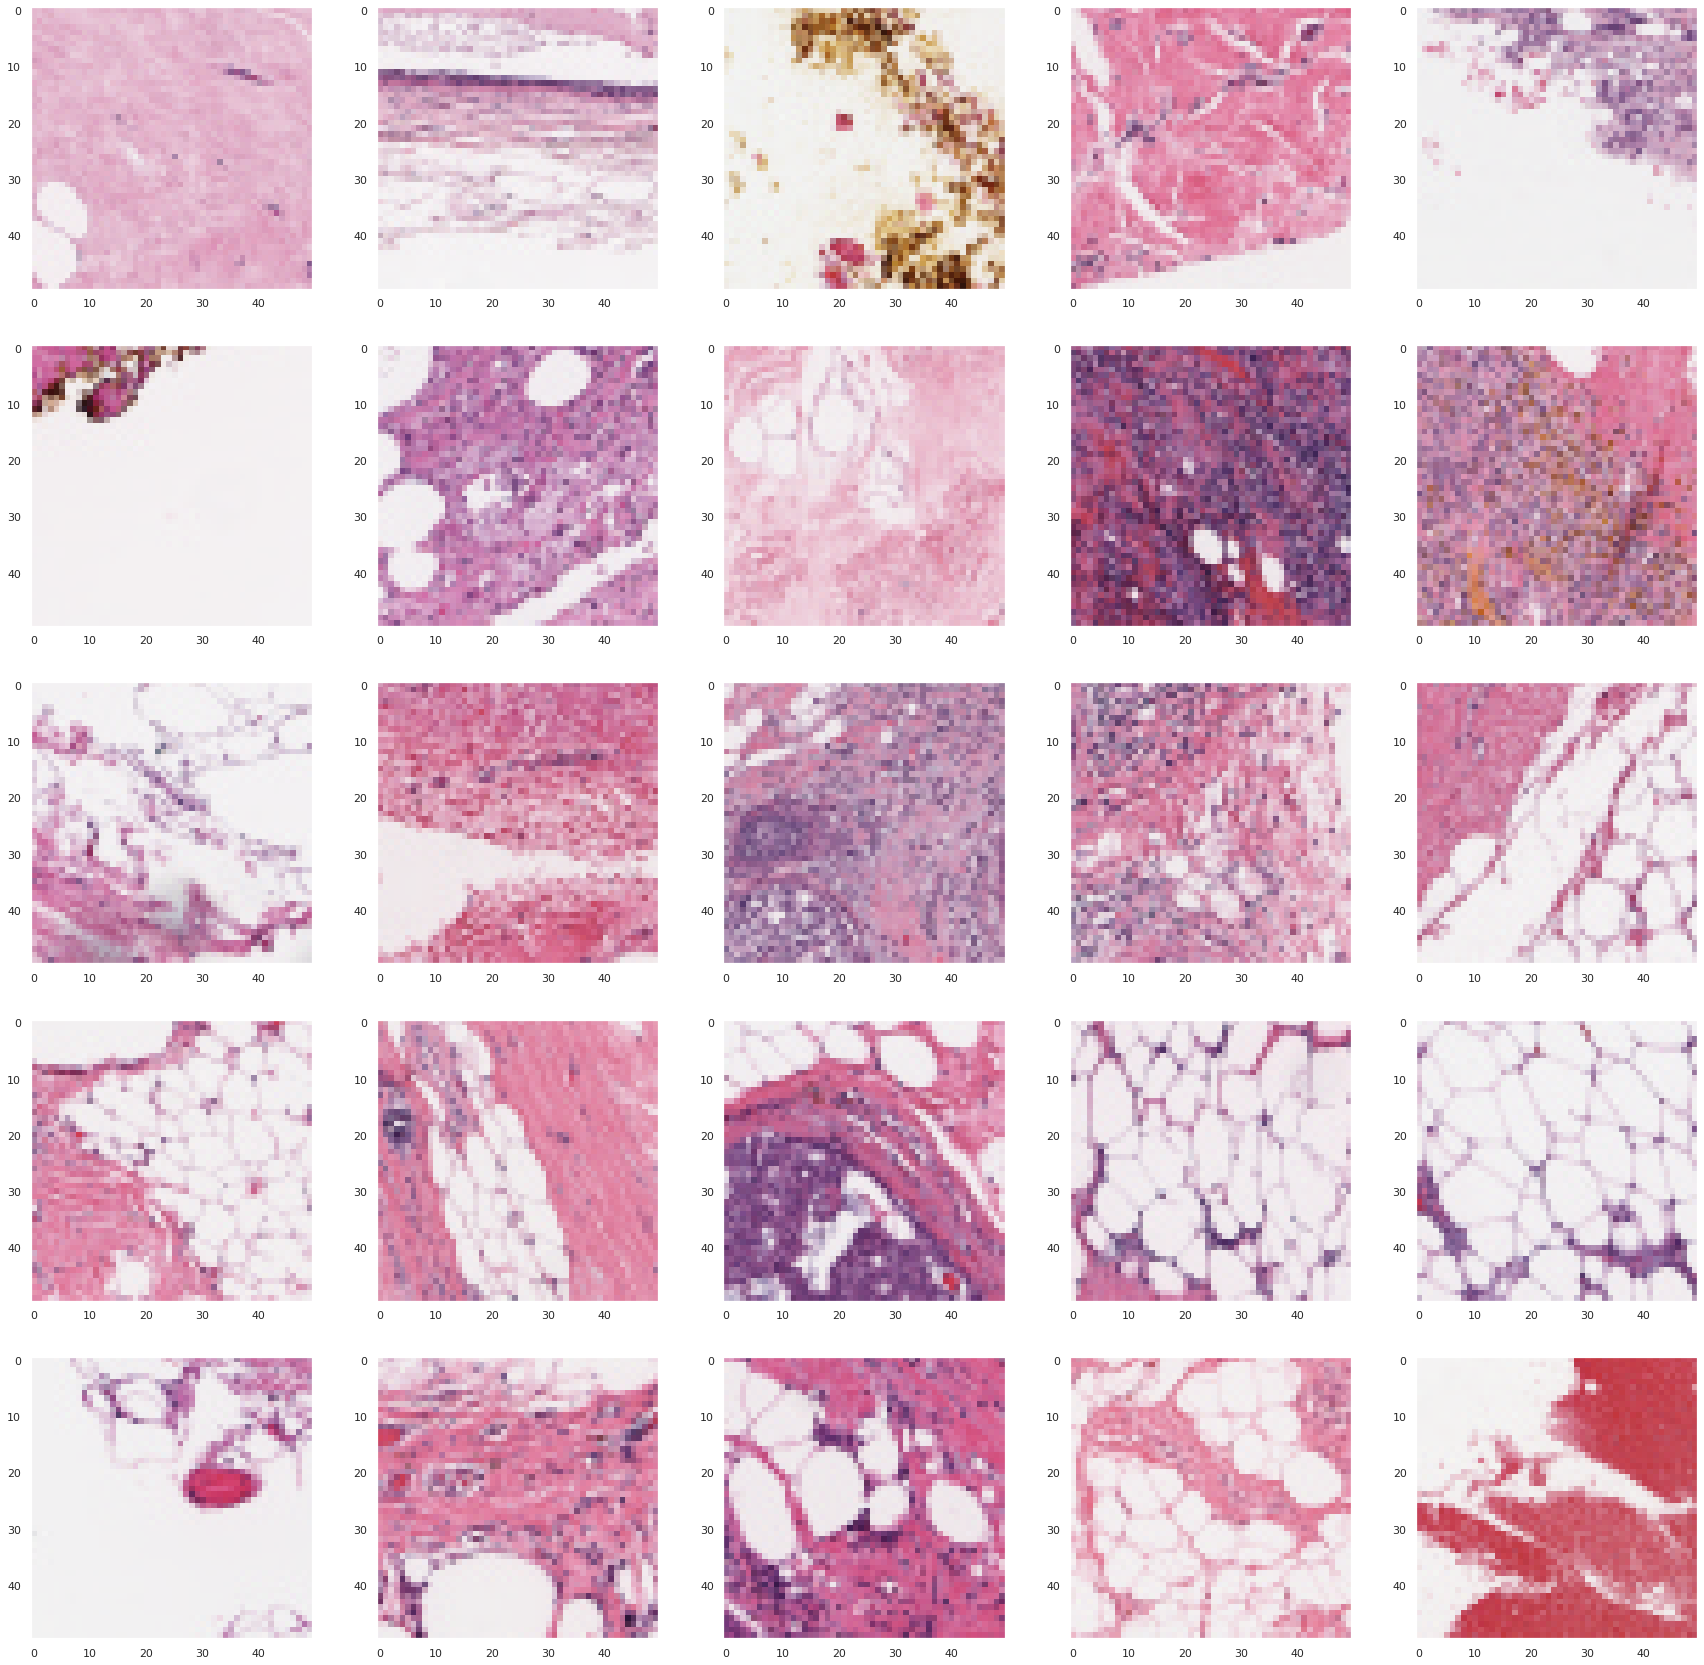

In [12]:
fig,ax = plt.subplots(n_rows,n_cols,figsize = (30,30))

for row in tqdm(range(n_rows)):
    for col in range(n_cols):
        # below is a counter to cycle through the image indices
        idx = negative_tissue[col + n_cols*row]
        img = io.imread(data.loc[idx, "path"])
        ax[row,col].imshow(img[:,:,:])
        ax[row,col].grid(False)

# **Understanding Breast Tissue**

We may utilise the coordinates of the cropped tissue cells that we collected before to recreate the patient's whole breast tissue. This allows us to investigate how the sick tissue differs from the healthy tissue. <br>

We may also look at the most prevalent locations where cancer occurs. It would be fascinating to create a heatmap showing the most prevalent locations where cancer is found. <br>

If crop position is important, we may be able to utilise it as an input feature in our model. <br>

To make things easier, we'll write a function that slices our existing dataframe and returns the values associated with a patient id.

In [13]:
def get_patient_df(patient_id):
    return data.loc[data['patient_id']== patient_id,:]


Binary Target Visualisation

  0%|          | 0/5 [00:00<?, ?it/s]

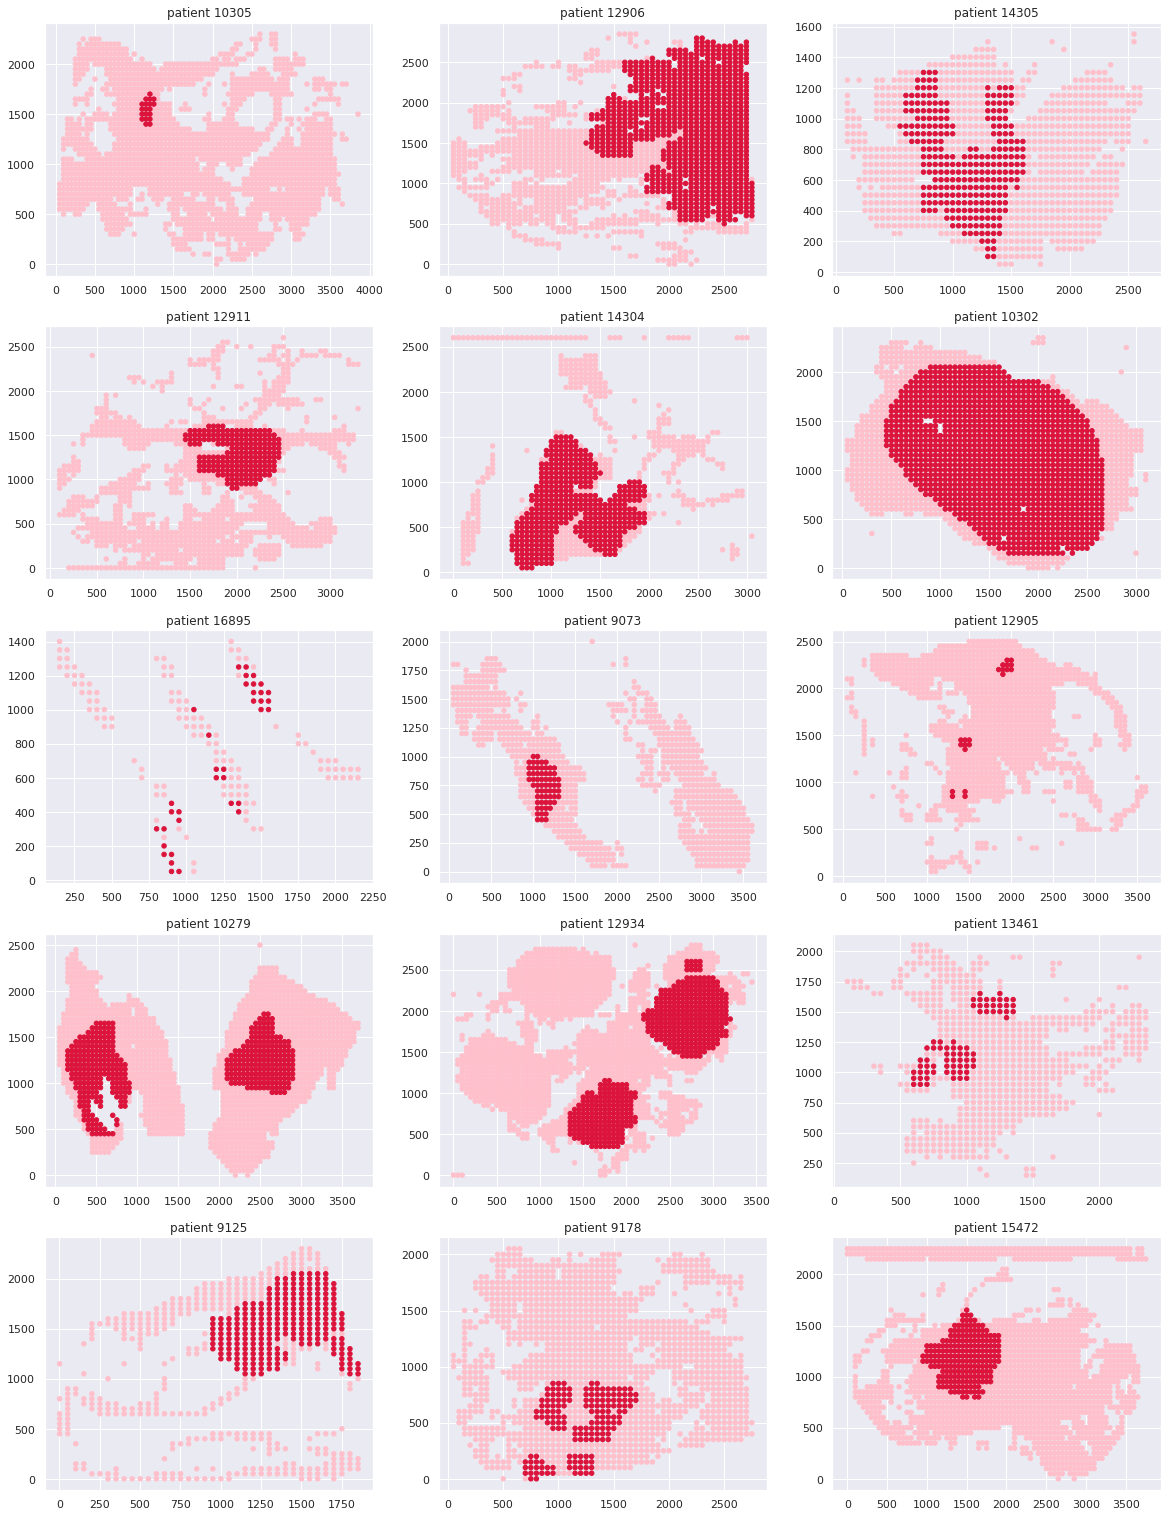

In [14]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols
colors = ['pink', 'crimson']

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 27))

patient_ids = np.random.choice( data.patient_id.unique(), size=n_imgs, replace=False)

for row in tqdm(range(n_rows)):
    for col in range(n_cols):
        patient_id = patient_ids[col + n_cols*row]
        patient_df = get_patient_df(patient_id)
        
        ax[row,col].scatter(patient_df.x.values, \
                            patient_df.y.values, \
                            c=patient_df.target.values,\
                            cmap=ListedColormap(colors), s=20)
        ax[row,col].set_title("patient " + patient_id)

# **Remodeling the Original Breast Tissue Image**

It's time to take our EDA to the next level. Instead of charting the goal values using the x-y coordinates, we now plot the pictures on their own x-y coordinates. This will assist us in seeing how malignant tissue appears from a macro perspective.

In [15]:
def visualise_breast_tissue(patient_id, df = data,pred = False, crop_dimension = [50,50]):
    # Plotting Settings
    plt.xticks([])
    plt.yticks([])
    # Get patient dataframe
    p_df = get_patient_df(patient_id)
    # Get the dimensions of the breast tissue image
    max_coord = np.max((*p_df.x,*p_df.y))
    # Allocate an array to fill image pixels in,use uint8 type as you don't need an int over 255
    grid = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    mask = 255*np.ones(shape = (max_coord + crop_dimension[0], max_coord + crop_dimension[1], 3)).astype(np.uint8)
    # Replace array values with values of the image
    for x,y,target,path in zip(p_df['x'],p_df['y'],p_df['target'],p_df['path']):
        try:
            img = io.imread(path)
            # Replace array values with cropped image values
            grid[y:y+crop_dimension[1],x:x+crop_dimension[0]] = img
            # Check if target is cancerous or not
            if target != 0:
                # If the target is cancerous then, replace array values with the color blue
                mask[y:y+crop_dimension[1],x:x+crop_dimension[0]] = [0,0,255]
        except: pass
    # if prediction is not specifies then show the image normally
    if pred == False:
        io.imshow(grid)
        img = grid
    # if prediction is specified then apply a mask to the areas that contain predicted cancerous cells
    else:
        # Specify the desired alpha value
        alpha = 0.78
        # This is step is very important, adding 2 numpy arrays sets the values to float64, which is why convert them back to uint8
        img = (mask * (1.0 - alpha) + grid * alpha).astype('uint8')
        io.imshow(img)
    return img

  0%|          | 0/5 [00:00<?, ?it/s]

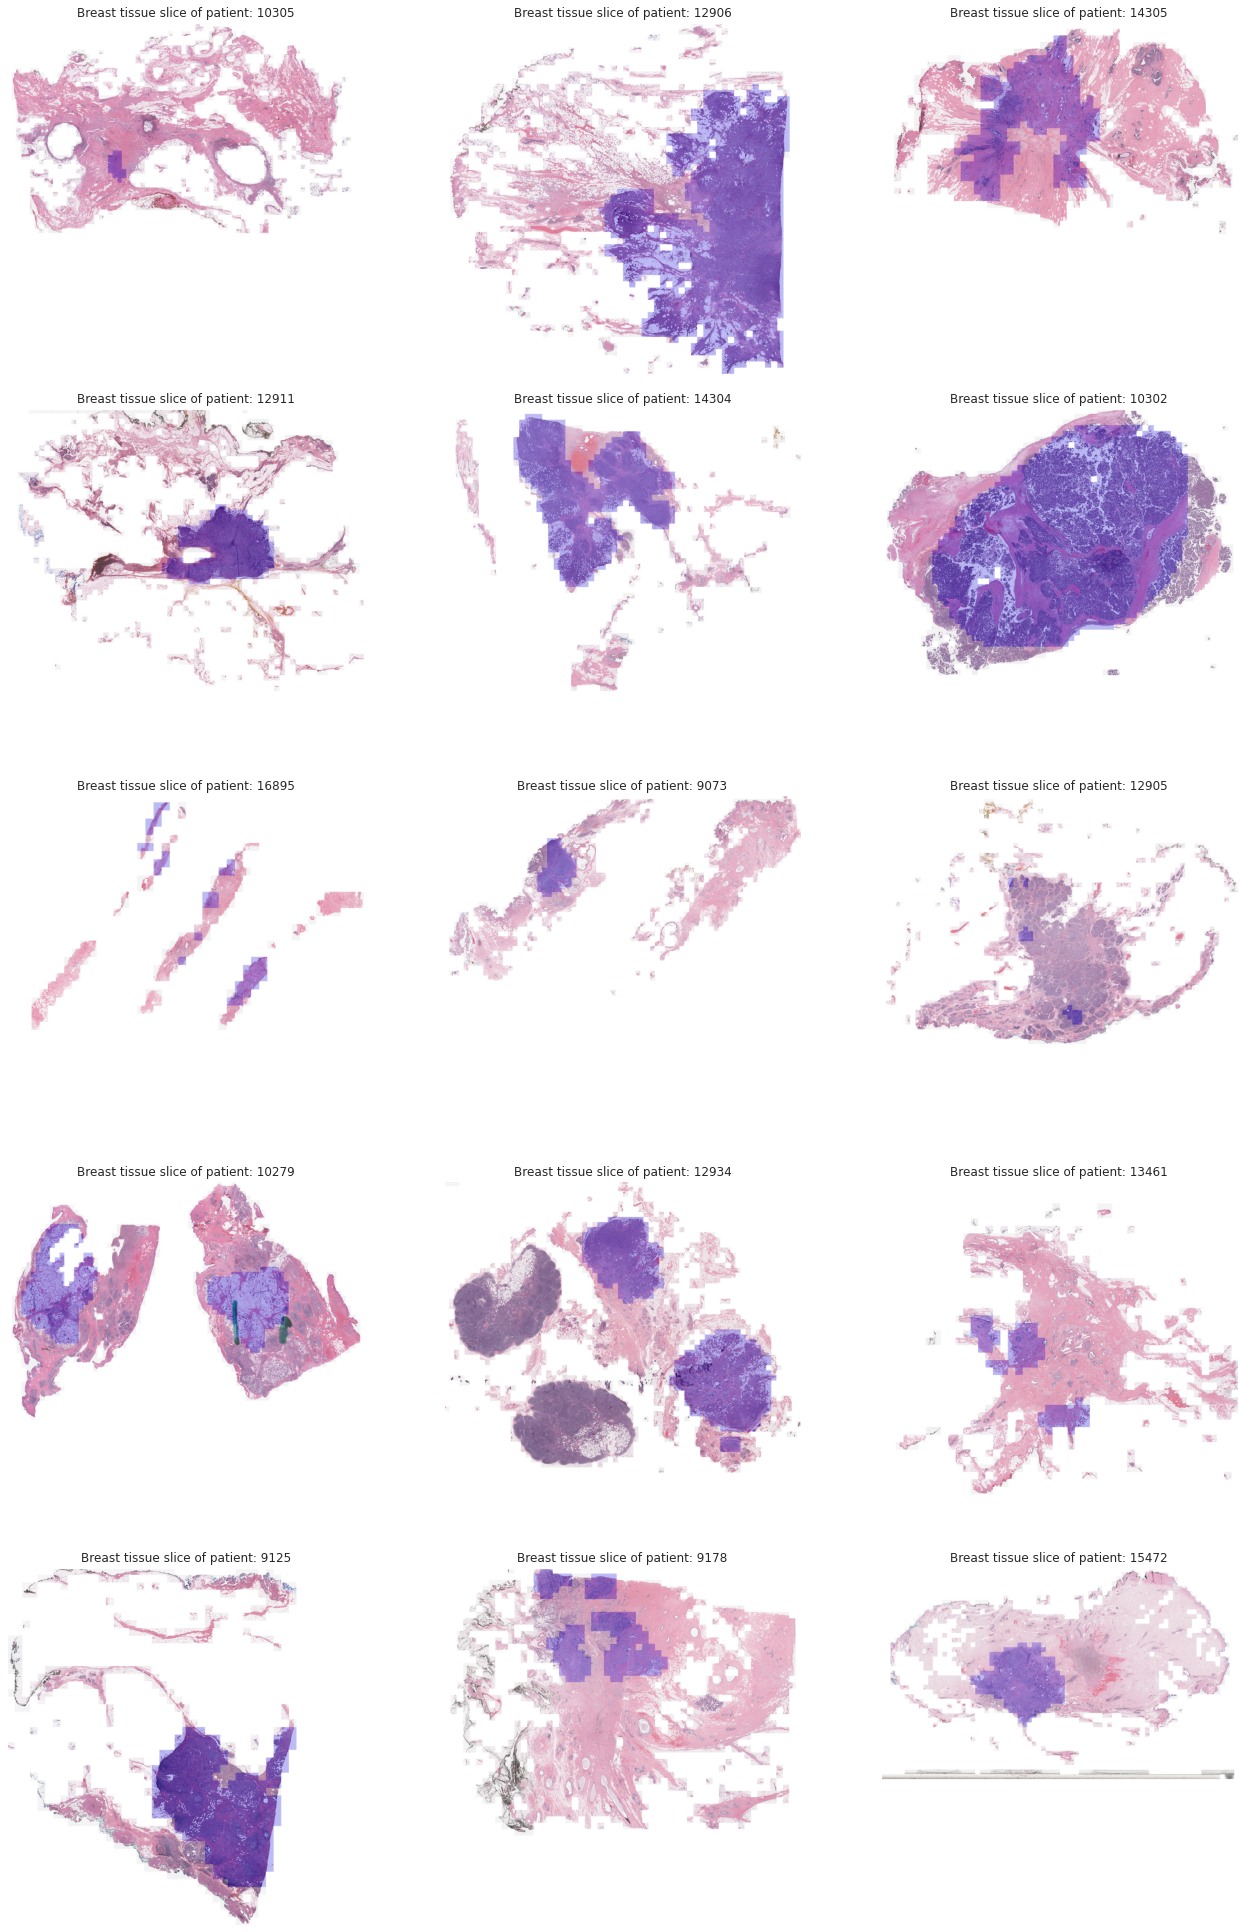

In [16]:
n_rows = 5
n_cols = 3
n_imgs = n_rows*n_cols

fig, ax = plt.subplots(n_rows,n_cols,figsize=(20, 27))

for row in tqdm(range(n_rows)):
    for col in range(n_cols):
        p_id = patient_ids[col + n_cols*row]
        
        img = visualise_breast_tissue(p_id, pred = True)
        ax[row,col].grid(False)
        ax[row,col].set_xticks([])
        ax[row,col].set_yticks([])
        ax[row,col].set_title("Breast tissue slice of patient: " + p_id)        
        ax[row,col].imshow(img)